# **04 ML model comparison and tuning**

## Objectives

* Hyperparameter Optimisation using multiple algorithms. 

## Inputs

* `data/processed/cybersecurity_intrusion_data_eda.csv`

## Outputs

* Best model found and analyzed for performance
* Prediction probabilities 
* `data/processed/cybersecurity_intrusion_data_pred.csv`

## Additional Comments

* The notebook adopts the shared template structure to stay consistent with the rest of the project.

---



## <img width="3%" height="3%" align="top"  src="https://codeinstitute.s3.amazonaws.com/predictive_analytics/jupyter_notebook_icons/Icon%204%20-%20Import%20Package%20for%20Learning.png"> Import Packages for Learning


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.pipeline import Pipeline

### Data Cleaning and Feature Engineering
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.encoding import OneHotEncoder

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

### CV algorithms 
from sklearn.model_selection import GridSearchCV

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")



You set a new current directory


In [ ]:
current_dir

'c:\\Users\\marka\\OneDrive\\Desktop\\Cyber'

---


We fitted multiple pipelines using a single algorithm while looking for the best hyperparameter combination for regression and classification tasks. However, how do you know which was better for a given ML task? 
* Let's learn how to use GridSearchCV and do Hyperparameter Optimisation using **multiple algorithms**
  
We will cover in this notebook:
* A technique to do a hyperparameter optimisation with multiple algorithms.
* A strategy for using this technique that typically reduces the time needed to train all algorithms.
* A strategy to refit the pipeline with only the most relevant features so you can deploy a pipeline that contains only the best features.
* **BONUS**: Here, we list the values of the most common hyperparameters for the algorithms we have covered in the course. You can use them as a starting point and as a reference for your personal projects or in your future workplace.
---


### <img width="3%" height="3%" align="top"  src="https://codeinstitute.s3.amazonaws.com/predictive_analytics/jupyter_notebook_icons/Icon%2010-%20Lesson%20Content.png">  Hyperparameter Optimisation with multiple algorithms


The workflow:

* Split the data.
* Define the pipeline and hyperparameter.
* Fit the pipeline (using a strategy that typically trains all the algorithms faster).
* Evaluate the pipeline.

In [ ]:
# Feature engineered cybersecurity dataset
df_clf = pd.read_csv('data/processed/cybersecurity_intrusion_data_eda.csv')
print(df_clf.shape)
df_clf.head()



NameError: name 'pd' is not defined

In [ ]:
df_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   session_id                8807 non-null   object 
 1   network_packet_size       8807 non-null   int64  
 2   protocol_type             8807 non-null   object 
 3   login_attempts            8807 non-null   int64  
 4   session_duration          8807 non-null   float64
 5   encryption_used           8807 non-null   object 
 6   ip_reputation_score       8807 non-null   float64
 7   failed_logins             8807 non-null   int64  
 8   browser_type              8807 non-null   object 
 9   unusual_time_access       8807 non-null   int64  
 10  attack_detected           8807 non-null   int64  
 11  session_duration_log      8807 non-null   float64
 12  ip_reputation_score_log   8807 non-null   float64
 13  network_packet_size_is64  8807 non-null   bool   
 14  fail_rat

## Statistical Process Control (SPC) on `attack_detected`
We treat the ordered session records as a manufacturing-like process and scan for any Western Electric style run rule violation: five or more consecutive intrusions (`attack_detected == 1`). These extended streaks flag potential process drift or an active attack campaign that requires immediate escalation.

In [ ]:
RUN_LENGTH = 8
attack_series = df_clf['attack_detected'].reset_index(drop=True)

consecutive_hits = []
current_run = 0
for value in attack_series:
    if value == 1:
        current_run += 1
    else:
        current_run = 0
    consecutive_hits.append(current_run)

spc_frame = pd.DataFrame({
    'index_position': attack_series.index,
    'attack_detected': attack_series,
    'consecutive_hits': consecutive_hits,
})

run_records = []
run_active = False
run_start = None
for idx, row in spc_frame[['attack_detected', 'consecutive_hits']].iterrows():
    run_len = row['consecutive_hits']
    if run_len >= RUN_LENGTH:
        if not run_active:
            run_active = True
            run_start = idx - run_len + 1
    else:
        if run_active:
            run_records.append({
                'run_start_idx': run_start,
                'run_end_idx': idx - 1,
                'run_length': spc_frame.loc[idx - 1, 'consecutive_hits'],
            })
            run_active = False
            run_start = None

if run_active and run_start is not None:
    run_records.append({
        'run_start_idx': run_start,
        'run_end_idx': len(spc_frame) - 1,
        'run_length': spc_frame.loc[len(spc_frame) - 1, 'consecutive_hits'],
    })

run_summary = pd.DataFrame(run_records)
run_summary

,run_start_idx,run_end_idx,run_length
0,125,131,7
1,190,195,6
2,320,327,8
3,484,491,8
4,977,983,7
5,2452,2457,6
6,2705,2711,7
7,2779,2784,6
8,2857,2862,6
9,3052,3058,7


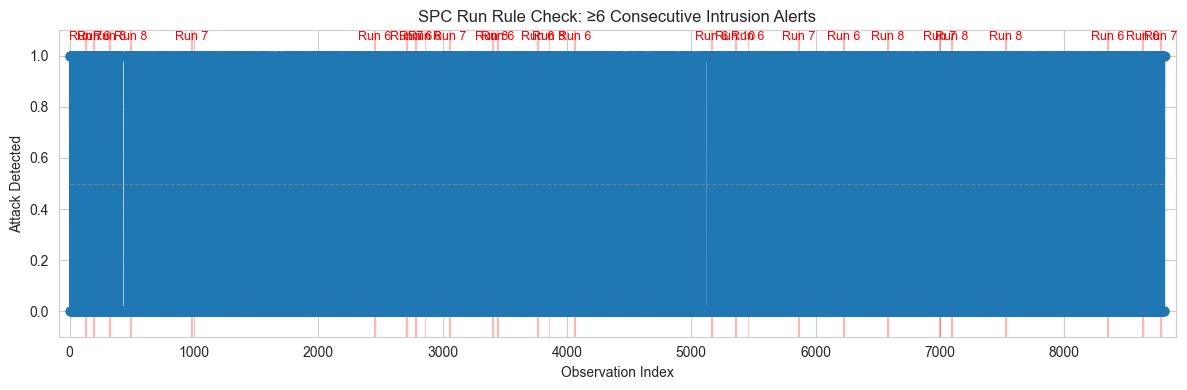

Found 27 SPC violations with runs of 6+ consecutive intrusions. Escalate for investigation.


In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(spc_frame['index_position'], spc_frame['attack_detected'], marker='o', linestyle='-', linewidth=1)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Observation Index')
ax.set_ylabel('Attack Detected')
ax.set_title(f'SPC Run Rule Check: ≥{RUN_LENGTH} Consecutive Intrusion Alerts')

for _, run in run_summary.iterrows():
    ax.axvspan(run['run_start_idx'], run['run_end_idx'], color='red', alpha=0.2)
    ax.text(
        (run['run_start_idx'] + run['run_end_idx']) / 2,
        1.05,
        f"Run {int(run['run_length'])}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='red',
    )

ax.hlines(0.5, xmin=spc_frame['index_position'].min(), xmax=spc_frame['index_position'].max(), colors='gray', linestyles='dashed', linewidth=0.8)
ax.margins(x=0.01)
plt.tight_layout()
plt.show()

if run_summary.empty:
    print(f'No SPC rule violations: no streaks of {RUN_LENGTH} or more consecutive intrusions found.')
else:
    print(f'Found {len(run_summary)} SPC violations with runs of {RUN_LENGTH}+ consecutive intrusions. Escalate for investigation.')

In [ ]:
# add flags for these to the df and save to an csv
spc_frame['is_attack'] = spc_frame['attack_detected'].apply(lambda x: 1 if x == 1 else 0)
# add the Session ID from the original df spc_frame['session_id'] = df_clf['session_id']
spc_frame['session_id'] = df_clf['session_id']
spc_frame.to_csv('spc_frame_with_flags.csv', index=False)

KeyError: 'session_id'

In [ ]:
"""
drop the columns that are not needed for modelling
#   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
* 0   session_id                8807 non-null   object 
* 1   network_packet_size       8807 non-null   int64  
 2   protocol_type             8807 non-null   object 
 3   login_attempts            8807 non-null   int64  
* 4   session_duration          8807 non-null   float64
 5   encryption_used           8807 non-null   object 
* 6   ip_reputation_score       8807 non-null   float64
 7   failed_logins             8807 non-null   int64  
 8   browser_type              8807 non-null   object 
 9   unusual_time_access       8807 non-null   int64  
 10  attack_detected           8807 non-null   int64  
 11  session_duration_log      8807 non-null   float64
 12  ip_reputation_score_log   8807 non-null   float64
 13  network_packet_size_is64  8807 non-null   bool   
 14  fail_ratio                8807 non-null   float64
"""
# drop the columns marked with * because they have been transformed or in the case of session ID it adds no info.
df_clf.drop(columns=['session_id', 'network_packet_size', 'session_duration', 'ip_reputation_score'], inplace=True)

KeyError: "['session_id', 'network_packet_size', 'session_duration', 'ip_reputation_score'] not found in axis"

In [ ]:
print(df_clf.shape)

(8807, 11)


We split the data into train and test sets.


In [ ]:
# The target is attack_detected 
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['attack_detected'],axis=1),
                                    df_clf['attack_detected'],
                                    test_size=0.2,
                                    random_state=101
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)


* Train set: (7045, 10) (7045,) 
* Test set: (1762, 10) (1762,)


 And define the pipeline steps considering:
* data cleaning (median imputation, categorical imputation).
* feature engineering (categorical encoding).
* feature scaling.
* feature selection (note we don't specify the algorithm, we pass in a variable called `model`).
*  and modelling (note we don't specify the algorithm, we pass in a variable called `model`).

"> Previously, we covered the definition of data cleaning and feature-engineering/scaling/selection steps, and in this exercise, we provide the appropriate actions (imputations and encoding).


We will use one-hot encoding as the categorical variable has no natural order between its categories.

browser_type (Chrome, Firefox, Safari, Edge, Unknown)
protocol_type (TCP, UDP, ICMP)
encryption_used (eg AES, DES, No encrytion)

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("median", MeanMedianImputer(imputation_method="median", variables=["ip_reputation_score_log"])),
        ("categorical_imputer", CategoricalImputer(imputation_method="frequent", variables=["browser_type"])),
        ("onehot", OneHotEncoder(variables=["browser_type", "protocol_type", "encryption_used"], drop_last=True)),
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline_base

Next, we create a Python class (HyperparameterOptimizationSearch) which aims to fit a set of algorithms with multiple hyperparameters. The logic is: 
* The developer defines a set of algorithms and their respective hyperparameter values.
* The code iterates on each algorithm and fits pipelines using GridSearchCV considering their respective hyperparameter values. The result is stored. 
* That is repeated for all algorithms that the user listed.
* Once all pipelines are trained, the developer can retrieve a list with a performance result summary and an object that contains all the trained pipelines. The developer can then subset the best pipeline.


Explanation of the major parts of the Python class:

* In the \__init__ method, you pass in models and params as a dictionary of algorithms and their respective hyperparameters.
* In the `fit` method, we loop on each algorithm and pass the algorithm to PipelineOptimization(). As a result, it will do a grid search on a set of hyperparameters for that given model. The result is stored, and the loop continues.
* The `score_summary` method returns all pipelines and a DataFrame with a performance summary for all of the algorithms.



In [ ]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


 We now define a list of models and their respective hyperparameters. 
* The first dictionary is related to the algorithms.
  * We create a dictionary where the key is the model name (you can use any name here, but we suggest using the estimator name), and the value is the estimator object. For example, for the decision tree, we use DecisionTreeClassifier(random_state=0).
* If it is a multiclass classification, so we consider all algorithms bar logistic regression (since that is more suitable for binary classification).


In [ ]:
models_search = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier":RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier":AdaBoostClassifier(random_state=0),
}


 The other dictionary relates to the hyperparameter values.
  * Its keys should map the keys from the models' dictionary.
  * For each key, the value will be a dictionary, whose keys will be the hyperparameter names and their values as a list of hyperparameter values.
  * Look at the example and see that RandomForestClassifier has two hyperparameters: n_estimators and max_depth. For each hyperparameter, we set a list with the determined values.
  * When you want to consider only the default hyperparameters, you just pass in an empty dictionary for a given algorithm. You will see that the other algorithms have an empty dict `{ }` as their hyperparameters, which means it will only consider the default hyperparameters. **But you may ask: why would we do that?**


In [ ]:
params_search = {
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{"model__n_estimators":[50,20],
                               "model__max_depth":[None,3,10]},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}


That is useful when we define a strategy to speed up the hyperparameter optimisation process.
* You noticed the idea is to fit multiple models with multiple hyperparameter options. But the time needed to compute all of that based on your hardware capability has a cost. 
* It would make sense to do a quick search using the default hyperparameters across all listed algorithms. The result will show the algorithms that look to fit your data the best, and this training process tends not to take long since it uses the default hyperparameters.
* Then you use the best two or three algorithms and finally do an extensive search so that you can fine-tune your pipeline performance.


Let's do a hyperparameter optimisation search using the **default hyperparameters values first**.


In [ ]:
params_search = {
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}


We now use our custom class `HyperparameterOptimizationSearch` to assign an object called search (you can use whatever name you wish).
* We pass in two arguments: models and params, which are the two dictionaries we set in the previous cells: models_search and params_search.
* The goal here is to use the default hyperparameters to find the type of algorithms that look to best fit your data.
* Next, we fit this object, meaning we will fit all the algorithms using GridSearchCV. Therefore, we pass in the `training data` (X_train, y_train), `scoring` (in this case, as it's a teaching example, we arbitrarily chose accuracy) and `cv` (we defined 2 to speed up the process).


In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1, # use all processors, but one
           cv=2)



Running GridSearchCV for DecisionTreeClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits



Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


Our method `.score_summary` returns a DataFrame with all the training results summary and a dictionary containing all pipelines.
* We grab both and first check the results summary.


In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary


,estimator,min_score,mean_score,max_score,std_score
2,GradientBoostingClassifier,0.860307,0.862313,0.86432,0.002007
1,RandomForestClassifier,0.844123,0.848119,0.852115,0.003996
3,ExtraTreesClassifier,0.81573,0.822142,0.828555,0.006413
0,DecisionTreeClassifier,0.770869,0.78041,0.789952,0.009541
4,AdaBoostClassifier,0.653322,0.65479,0.656259,0.001468


**On which algorithms would you spend time doing an extensive hyperparameter search?**
* It depends on how distant the performance distribution is amongst the top performers.

* However, there could be a case where for example, the top four had similar performance on the default hyperparameter, then you would do an extensive hyperparameter optimisation on these four.
 Let's define the new hyperparameters for the extensive search.
* You don't need to pass in the same quantity of hyperparameters for each algorithm, and the assigned values in the list will depend on the hyperparameter.
* There is no fixed number of values to be parsed in this list; just remember the more values and hyperparameters you parse, the more time it will take to fit all possible combinations.
# you don't have to list in any specific order here necessarily 


In [ ]:
models_search = {
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
    "RandomForestClassifier":RandomForestClassifier(random_state=0),
}

params_search = {
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
    "GradientBoostingClassifier":{"model__n_estimators": [20,50],
                            },
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    "RandomForestClassifier":{"model__n_estimators": [40,20],
                            },
}


Let's fit again using our HyperparameterOptimizationSearch class and our updated information on models_search and params_search.
* The other arguments remain the same.
* The goal here is to do an extensive search on the algorithms that performed better in a default hyperparameter optimisation.


In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1,
           cv=2)



Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits



Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


<img width="3%" height="3%" align="top"  src=" https://codeinstitute.s3.amazonaws.com/predictive_analytics/jupyter_notebook_icons/Result.png
">
 Let's check the results summary with `.score_summary`
* We could do a further round of extensive search with more hyperparameters and consider values around those that demonstrated good performance in this round. But for this teaching example, we are happy with the current search.


In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary


,estimator,min_score,mean_score,max_score,std_score,model__n_estimators
0,GradientBoostingClassifier,0.86343,0.864443,0.865456,0.001013,20
1,GradientBoostingClassifier,0.86343,0.864443,0.865456,0.001013,50
3,RandomForestClassifier,0.845542,0.847835,0.850128,0.002293,20
2,RandomForestClassifier,0.842135,0.845422,0.848708,0.003287,40


Programmatically, we grab the best model name by using `.iloc[ ]` on the first row and column from the previous DataFrame.


In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model


'GradientBoostingClassifier'

Let's get the best model parameters.


In [ ]:
grid_search_pipelines[best_model].best_params_


{'model__n_estimators': 20}

<img width="3%" height="3%" align="top"  src="https://codeinstitute.s3.amazonaws.com/predictive_analytics/jupyter_notebook_icons/Icon%207-%20Note.png"> Finally, we want to grab the best pipeline.
* The object grid_search_pipelines contains all trained pipelines. We first subset the pipelines from the algorithm having the best performance (with `best_model`), then used `.best_estimator_` to retrieve the pipeline that has the algorithm and hyperparameter configuration that best suits our data.


In [ ]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline


Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['ip_reputation_score_log'])),
                ('categorical_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['browser_type'])),
                ('onehot',
                 OneHotEncoder(drop_last=True,
                               variables=['browser_type', 'protocol_type',
                                          'encryption_used'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model',
                 GradientBoostingClassifier(n_estimators=20, random_state=0))])

<img width="3%" height="3%" align="top"  src="https://codeinstitute.s3.amazonaws.com/predictive_analytics/jupyter_notebook_icons/Icon%207-%20Note.png"> The best pipeline is a tree-based algorithm, so we can check the most important features with `.feature_importances_`

* The information on the `“best features”` is on the pipeline’s “feature selection” step as a boolean list. We get this list to subset the train set columns.
* Go through the pseudo code and code comments to understand the logic.
* Make sure you understand the variable data_cleaning_feat_eng_steps. If you use this code in your milestone project, you will likely need to update this value to the appropriate one for your pipeline.
after data cleaning and feature engineering, the feature space may change
for example, you may drop variables, or you may add variables, such as a "date" variable
if you extract the day, month and year, for example.
then you ask yourself: how many data cleaning and feature engineering steps does your pipeline have?
in our case three: median, categorical_imputer and ordinal



In [ ]:
# run the best pipeline on the test set
test_score = best_pipeline.score(X_test, y_test)
test_score

0.8711691259931895

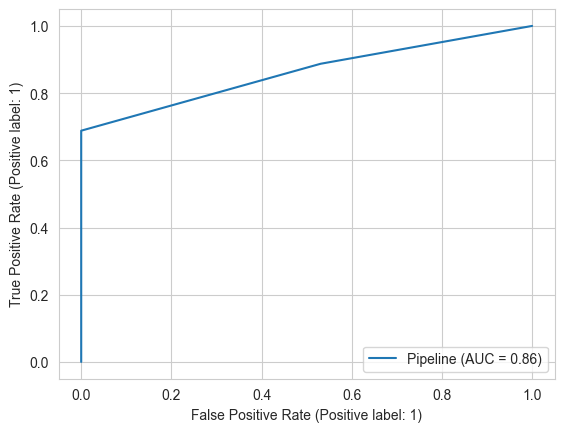

In [ ]:
# ROC AUC curve for improved model
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(best_pipeline, X_test, y_test)


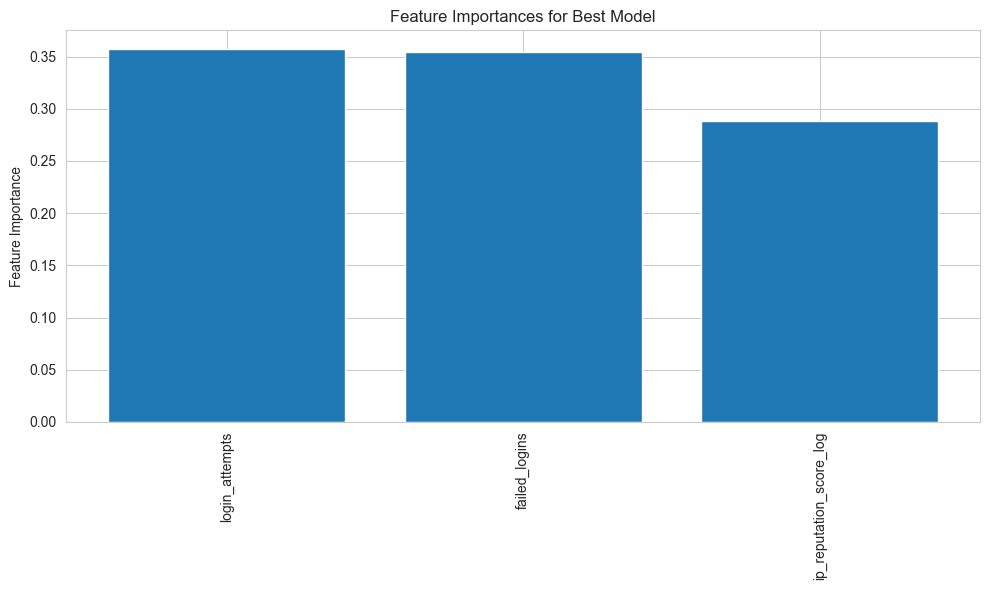

,Feature,Importance
0,login_attempts,0.357208
1,failed_logins,0.354379
2,ip_reputation_score_log,0.288413


In [ ]:
# what are the feature importances for the best model?
feature_importances = best_pipeline.named_steps["model"].feature_importances_

# derive feature names from the preprocessing steps before feature selection
data_cleaning_feat_eng_steps = 3
preprocessing_steps = Pipeline(best_pipeline.steps[:data_cleaning_feat_eng_steps])
transformed_X_train = preprocessing_steps.transform(X_train)
selected_mask = best_pipeline.named_steps["feat_selection"].get_support()
best_features = transformed_X_train.columns[selected_mask]

df_feature_importance = (
    pd.DataFrame({"Feature": best_features, "Importance": feature_importances})
    .sort_values(by="Importance", ascending=False)
)

plt.figure(figsize=(10, 6))
plt.bar(df_feature_importance["Feature"], df_feature_importance["Importance"])
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")
plt.title("Feature Importances for Best Model")
plt.tight_layout()
plt.show()

df_feature_importance

In [ ]:
data_cleaning_feat_eng_steps = 3
# we get these steps with .steps[] starting from 0 until the value we assigned above
# then we .transform() to the train set and extract the columns
columns_after_data_cleaning_feat_eng = (Pipeline(best_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)



we get the boolean list indicating the best features with best_pipeline['feat_selection'].get_support()
and use this list to subset columns_after_data_cleaning_feat_eng


* These are the 3 most important features in descending order. The model was trained on them: 
['login_attempts', 'failed_logins', 'ip_reputation_score_log']


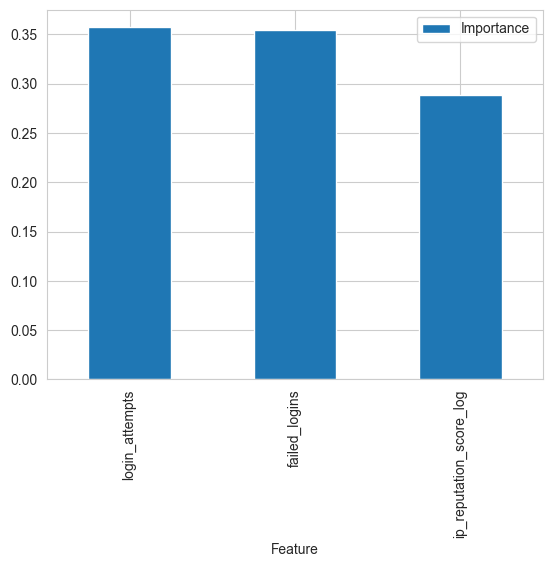

In [ ]:
best_features = columns_after_data_cleaning_feat_eng[best_pipeline['feat_selection'].get_support()].to_list()


# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': best_features,
          'Importance': best_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()


Finally, we evaluate the pipeline as usual with our custom function for classification tasks.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X,y,pipeline,label_map):

  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction),"\n")


def clf_performance(X_train,y_train,X_test,y_test,pipeline,label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test,y_test,pipeline,label_map)


We pass in the arguments we are familiar with.
* Note the performance on the test set is the same as in the train set.
* for label_map, we get the classes name with .unique()


In [ ]:
label_map = df_clf['attack_detected'].astype(str).unique()
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=best_pipeline,
                label_map=label_map
                # In this case, the target variable is encoded as categories and we
                # get the values with .unique() 
                )


#### Train Set #### 

---  Confusion Matrix  ---
             Actual 1 Actual 0
Prediction 1     4025      953
Prediction 0        0     2067


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      4025
           1       1.00      0.68      0.81      3020

    accuracy                           0.86      7045
   macro avg       0.90      0.84      0.85      7045
weighted avg       0.89      0.86      0.86      7045
 

#### Test Set ####

---  Confusion Matrix  ---
             Actual 1 Actual 0
Prediction 1     1034      227
Prediction 0        0      501


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1034
           1       1.00      0.69      0.82       728

    accuracy                           0.87      1762
   macro avg       0.91      0.84      0.86      1762
weighted avg       0.89      0.87      0.87      

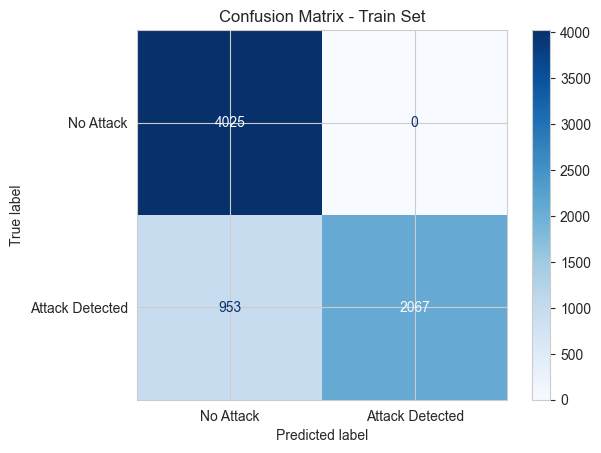

Classification Report - Train Set:

                 precision    recall  f1-score   support

      No Attack       0.81      1.00      0.89      4025
Attack Detected       1.00      0.68      0.81      3020

       accuracy                           0.86      7045
      macro avg       0.90      0.84      0.85      7045
   weighted avg       0.89      0.86      0.86      7045



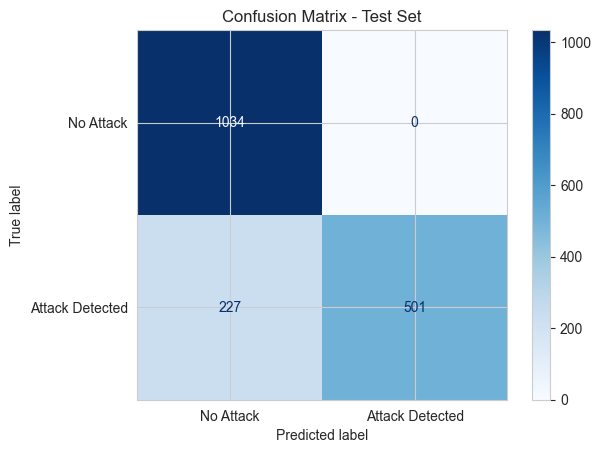

Classification Report - Test Set:

                 precision    recall  f1-score   support

      No Attack       0.82      1.00      0.90      1034
Attack Detected       1.00      0.69      0.82       728

       accuracy                           0.87      1762
      macro avg       0.91      0.84      0.86      1762
   weighted avg       0.89      0.87      0.87      1762



In [ ]:
# plot the confusion matrix and classification report for train and test sets
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def plot_confusion_matrix_and_report(X, y, pipeline, dataset_type):
    y_pred = pipeline.predict(X)

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X,
        y,
        display_labels=['No Attack', 'Attack Detected'],
        cmap=plt.cm.Blues,
        normalize=None
    )
    disp.ax_.set_title(f'Confusion Matrix - {dataset_type} Set')
    plt.show()

    # Classification Report
    print(f'Classification Report - {dataset_type} Set:\n')
    print(classification_report(y, y_pred, target_names=['No Attack', 'Attack Detected']))
# Plot for Train Set
plot_confusion_matrix_and_report(X_train, y_train, best_pipeline, 'Train')
# Plot for Test Set
plot_confusion_matrix_and_report(X_test, y_test, best_pipeline, 'Test')


c:\Users\marka\OneDrive\Desktop\Cyber\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\marka\OneDrive\Desktop\Cyber\.venv\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\marka\OneDrive\Desktop\Cyber\.venv\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


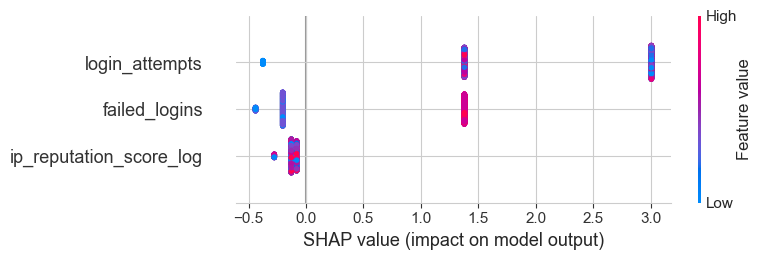

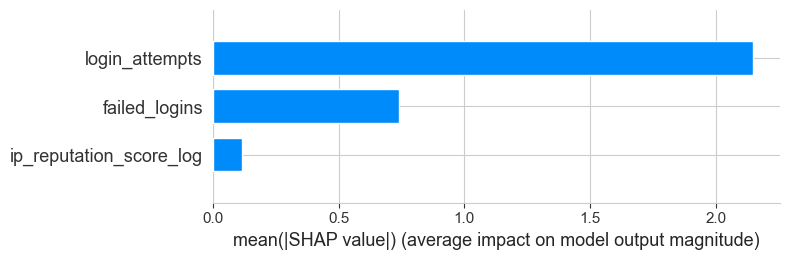

In [ ]:
# Confusion matrix and classification report for the best model
import shap
X_test_preprocessed = preprocessing_steps.transform(X_test)
X_test_selected = best_pipeline.named_steps["feat_selection"].transform(X_test_preprocessed)

explainer = shap.TreeExplainer(best_pipeline.named_steps["model"])
shap_values = explainer(X_test_selected)

shap.summary_plot(
    shap_values,
    features=X_test_selected,
    feature_names=best_features,
)
# horizontal plot
shap.summary_plot(
    shap_values,
    features=X_test_selected,
    feature_names=best_features,
    plot_type="bar"
)

In [ ]:
# get the probabilities for the positive class
y_probs = best_pipeline.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
roc_auc = roc_auc_score(y_test, y_probs)
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


ROC AUC: 0.8609
PR AUC: 0.8953


In [ ]:
# save the probabilities scores to a CSV file
import pandas as pd
# include the session ID in the output
# so 1 becomes SID_00001
probs_df = pd.DataFrame({'session_id': X_test.index, 'y_true': y_test, 'y_prob': y_probs})
probs_df['session_id'] = 'SID_' + probs_df['session_id'].astype(str).str.zfill(5)
probs_df.to_csv('data/processed/cybersecurity_intrusion_model_pred.csv', index=False)



---
